In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
    
}
</style>

In [31]:
# This cell needs to be executed first for the initial
# visualization to work. All important functions used here
# are explained later.

from IPython.display import HTML
import sys
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
import pandas as pd
from pylab import Rectangle
import seaborn as sns
from copy import deepcopy, copy
%matplotlib inline

data_file = "data/dev-test-train.pl-en"
num_sent = sys.maxsize
num_iter = 10

def get_bitext(file_name, num_sent):
    return [[sentence.strip().split() for sentence in pair.split(' ||| ')] for pair in open(file_name)][:num_sent]

def train(bitext, num_iter):
    k = 0
    theta = initialize_theta(bitext)
    print("\nInitialization:\n")
    while k < num_iter:
        k += 1
        theta = iteration(theta, bitext)
        print("\nIteration {}:\n".format(str(k)))
    return theta

def initialize_theta(bitext):
    f_vocab = set()
    e_vocab = set()
    for (f, e) in bitext:
        f_vocab.update(f)
        e_vocab.update(e)
    theta = {}
    default_p = 1.0/len(f_vocab)
    for e in e_vocab:
        theta[e] = defaultdict(float)
        for f in f_vocab:
            theta[e][f] = default_p
    return theta

def expectation(theta, bitext):
    e_count = defaultdict(float)
    fe_count = defaultdict(float)
    for (n, (f, e)) in enumerate(bitext):
        for f_i in f:
            z = 0
            for e_j in e:
                z += theta[e_j][f_i]
            for e_j in e:
                c = theta[e_j][f_i] / z
                fe_count[(f_i, e_j)] += c
                e_count[e_j] += c
    return e_count, fe_count

def maximization(theta, e_count, fe_count):
    new_theta = deepcopy(theta)
    for e_i in new_theta:
        for f_j in new_theta[e_i]:
            if (f_j, e_i) in fe_count:
                new_theta[e_i][f_j] = fe_count[(f_j, e_i)]/e_count[e_i]
            else:
                new_theta[e_i][f_j] = 0
    return new_theta

def iteration(theta, bitext):
    e_count, fe_count = expectation(theta, bitext)
    new_theta = maximization(theta, e_count, fe_count)
    return new_theta

def align(f_sent, e_sent, theta):
    a = []
    for j in range(0, len(f_sent)):
        best_prob = 0
        best_i = 0
        for i in range(0, len(e_sent)):
            if theta[e_sent[i]][f_sent[j]] > best_prob:
                best_prob = theta[e_sent[i]][f_sent[j]]
                best_i = i
        a.append((j, best_i))
    return a

#######################################
# STATIC ILUSTRATIONS
#######################################
def get_thetas(bitext, num_iter):
    """
    runs the training procedure for a given number of iterations,
    stores parameter values after each iteration, and returns them
    as a list
    
    Args:
        bitext (list of tuples): corpus of translation pairs
        num_iter (int): number of iterations of EM training to be run
    """
    k = 0
    thetas=[]
    theta = initialize_theta(bitext)
    thetas.append(theta)
    while k < num_iter:
        k += 1
        new_theta = iteration(theta, bitext)
        theta = new_theta
        thetas.append(new_theta)
    return thetas
    
def show_sent_data(at_iter, sent_index=0, word_index=0):
    """
    draws a sentence pair and display translation and alignment probabilities
    for a chosen word in the Foreign sentence
    
    Args:
        at_iter (int): determines the iteration which produces the parameters
            used for visualization
        sent_index (int): determines sentence pair to be visualized; if larger than
            the number of pairs in the corpus, defaults to the last pair
        word_index (int): determines Foreign word whose translation and alignment
            probabilities will be visualized; if larger than the number of words
            in the Foreign sentence, defaults to the last word
    """
    if sent_index > len(bitext)-1:
        sent_index = len(bitext)-1
    if word_index > len(bitext[sent_index][0])-1:
        word_index = len(bitext[sent_index][0])-1
    # get model parameters at selected iteration
    theta = thetas20[at_iter]
    # get selected foreign and english sentences
    f, e = bitext[sent_index]
    # get coordinates for plotting the sentences
    coords = get_coordinates(bitext, one_sent=True, sent_index=sent_index, word_index=word_index)
    annot1_y = [coords['y_e'][0]+0.5]*(len(coords['y_e'])+1)
    annot2_y = [coords['y_e'][0]+1]*(len(coords['y_e'])+1)
    annot_x = [0] + coords['x_e']
    annot_color = ['#1a75ff'] + (['#000000']*len(coords['x_e']))
    # get alignment probabilities for the selected word and format them as strings
    alignment_p = ['{:.2f}'.format(p) for p in 
                   get_alignment_probabilities(f, e, theta, one_word=True, word_index=word_index)[0]]
    annot1_words = ['alignment\nprobability'] + alignment_p
    # get translation probabilities for the selected word and format them as strings
    translation_p = ['{:.2f}'.format(p) for p in 
                      get_translation_probabilities(f, e, theta, one_word=True, word_index=word_index)[word_index]]
    annot2_words = ['translation\nprobability'] + translation_p
    # plot the data
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes()
    plt.axis('off')
    # plot the words and probabilites
    ax.scatter(coords['x_f']+coords['x_e']+annot_x*2,
               coords['y_f']+coords['y_e']+annot1_y+annot2_y,
               s=30, c='white', marker='o', lw=0, alpha=1)
    plot_words(ax, coords['x_f'], coords['y_f'], coords['w_f'], 'top')
    plot_words(ax, coords['x_e'], coords['y_e'], coords['w_e'], 'bottom')
    plot_words(ax, annot_x, annot1_y, annot1_words, 'bottom', weight='normal', color=annot_color)
    plot_words(ax, annot_x, annot2_y, annot2_words, 'bottom', weight='normal', color=annot_color)
    # plot the alignment lines, with line weight proportional to alignment probability
    w_start = len(f)*word_index
    raw_line_weights = get_line_weights([bitext[sent_index]], at_iter, thetas=[theta])[0]
    line_weights = [w*10 for w in raw_line_weights][w_start:(w_start+len(f))]
    edge_coords = coords['edges']
    lines = [ax.plot(xy[0], xy[1],alpha=0.9,lw=w,linestyle='-',color='#1a75ff')[0] for xy,w
             in zip(coords['edges'], line_weights)]
    plt.show()

def draw_iteration(at_iter, bitext):
    """
    For a given iteration, draws the translation probability table from
    the previous iteration, alignment probabilities and expected alignment counts
    collected during current iteration, and an updated translation table
    
    Args:
        at_iter (int): iteration to be visualized
        bitext (list of tuples): corpus of translation pairs
    """
    theta_before = thetas20[at_iter-1]
    theta_after = thetas20[at_iter]
    order_dict = list(theta_before.values())[0]
    f_order = list(order_dict.keys())
    fig = plt.figure(1, figsize=(14, 10))
    
    # first translation table
    ax1 = plt.subplot(221)
    draw_translation_table(bitext, theta_before, f_order, fig=ax1)
    plt.title('Parameters at the end of iteration {}'.format(str(at_iter-1)), color='#1a75ff', y=1.08)
    draw_box(ax1, color='#1a75ff')
    
    # alignment graph
    ax2 = plt.subplot(222)
    line_weights = [[w*(10.0/2) for w in sublist] for sublist in get_line_weights(bitext, at_iter-1)]
    coordinates = get_coordinates(bitext)
    ax2.axis('off')
    ax2.scatter(coordinates['x_f']+coordinates['x_e'], coordinates['y_f']+coordinates['y_e'],
           s=30, c='white', marker='o', lw=0,alpha=1)
    plot_words(ax2, coordinates['x_f'], coordinates['y_f'], coordinates['w_f'], 'top')
    plot_words(ax2, coordinates['x_e'], coordinates['y_e'], coordinates['w_e'], 'bottom')
    lines = [ax2.plot(xy[0], xy[1],alpha=0.9,linestyle='-',lw=w,color='#b20000')[0]
             for xy,w in zip(coordinates['edges'],line_weights[at_iter-1])]
    plt.title('Alignment probabilities and expected counts\nafter Expectation step of iteration {}'.format(str(at_iter)),
              color='#b20000')

    # expected alignment counts
    ax3 = plt.subplot(224)
    draw_expected_counts(bitext, theta_before, f_order, fig=ax3)
    draw_box(ax3, tall=True, color='#b20000')
    
    # second translation table
    ax4 = plt.subplot(223)
    draw_translation_table(bitext, theta_after, f_order, fig=ax4)
    plt.title('Parameters at the end of iteration {}'.format(str(at_iter)), color='#1a75ff', y=1.08)
    draw_box(ax4, color='#1a75ff')
    
    plt.show()

    
def draw_box(ax, color, tall=False):
    height = 1.4 if not tall else 9.8
    autoAxis = ax.axis()
    rec = Rectangle((autoAxis[0]-1.3,autoAxis[2]-0.2),
                     (autoAxis[1]-autoAxis[0])+3.2,
                     (autoAxis[3]-autoAxis[2])+height,
                     fill=False,lw=2,color=color)
    rec = ax.add_patch(rec)
    rec.set_clip_on(False)
    
def show_alignments(initialize=initialize_theta):
    train_and_draw(bitext, num_iter, draw_a=True, initialize=initialize)

def show_translation_tables(initialize=initialize_theta):
    train_and_draw(bitext, num_iter, draw_p=True, initialize=initialize)
    
def train_and_draw(bitext, num_iter, draw_a=False, draw_p=False, initialize=initialize_theta):
    k = 0
    theta = initialize(bitext)
    order_dict = list(theta.values())[0]
    f_order = list(order_dict.keys())
    if draw_a or draw_p:
        print("\nInitialization:\n")
    draw(bitext, theta, draw_a, draw_p, f_order)
    while k < num_iter:
        k += 1
        new_theta = iteration(theta, bitext)
        theta = new_theta
        if draw_a or draw_p:
            print("\nIteration {}:\n".format(str(k)))
        draw(bitext, theta, draw_a, draw_p, f_order)
    return theta

def draw(bitext, theta, draw_a, draw_p, f_order):
    if draw_p:
        draw_translation_table(bitext, theta, f_order)
    if draw_a:
        draw_alignments(bitext, theta)

def draw_alignments(bitext, theta, fig=None, scale=None, correct=False):
    if not fig:
        plt.figure(figsize=(10, 15))
    if not correct:
        line_weights = [w*(10.0/2) for w in get_line_weights(bitext, thetas=[theta])[0]]
    else:
        line_weights = []
        for n, alignments in enumerate(correct_alignments):
            for j in range(0, len(bitext[n][0])):
                weights = [2 if (j,i) in alignments else 0 for i in range(0, len(bitext[n][1]))]
                line_weights.extend(weights)
    coordinates = get_coordinates(bitext)
    plt.axis('off')
    plt.scatter(coordinates['x_f']+coordinates['x_e'], coordinates['y_f']+coordinates['y_e'],
           s=30, c='white', marker='o', lw=0,alpha=1)
    plot_words(plt, coordinates['x_f'], coordinates['y_f'], coordinates['w_f'], 'top')
    plot_words(plt, coordinates['x_e'], coordinates['y_e'], coordinates['w_e'], 'bottom')
    lines = [plt.plot(xy[0], xy[1],alpha=0.9,linestyle='-',lw=w,color='#1a75ff')[0]
             for xy,w in zip(coordinates['edges'],line_weights)]
    if not fig:
        plt.show()
        
def draw_actual_alignments(bitext):
    # meant only to be used for the initial example
    draw_alignments(bitext, thetas20[-1], correct=True)

correct_alignments = [[(0,0), (1,3), (2,2), (3,1), (4,4)],
                      [(0,0), (1,1), (2,2), (3,3)],
                      [(0,0), (1,2), (2,1), (3,3), (4,4)]]

def draw_translation_table(bitext, theta, f_order=None, fig=None):
    if not fig:
        plt.figure(figsize=(7, 5))
    if not f_order:
        order_dict = list(theta.values())[0]
        f_order = list(order_dict.keys())
    theta_arrays = {e: [theta[e][f] for f in f_order] for e in theta.keys()}
    theta2frame = pd.DataFrame.from_dict(theta_arrays, orient="index")
    theta2frame.columns = f_order
    data = theta2frame.round(2)
    sns.set(font_scale=1.2)
    sns.set_style({"savefig.dpi": 100})
    ax = sns.heatmap(data, cmap=plt.cm.Blues, linewidths=.1, annot=True, fmt="2g", vmin=0, vmax=1)
    ax.xaxis.tick_top()
    plt.yticks(rotation=0)
    if not fig:
        plt.show()
        
def draw_expected_counts(bitext, theta, f_order=None, fig=None):
    if not fig:
        plt.figure(figsize=(7, 5))
    if not f_order:
        f_order = theta.values()[0].keys()
    _, fe_count = expectation(theta, bitext)
    fe_dict = {}
    for f in theta.keys():
        fe_dict[f] = {}
        for e in list(list(theta.values())[0].keys()):
            fe_dict[f][e] = fe_count[(e,f)] if (e,f) in fe_count else 0        
    counts_arrays = {e: [fe_dict[e][f] for f in f_order] for e in fe_dict.keys()}
    counts2frame = pd.DataFrame.from_dict(counts_arrays, orient="index")
    counts2frame.columns = f_order
    data = counts2frame.round(2)
    sns.set(font_scale=1.2)
    sns.set_style({"savefig.dpi": 100})
    ax = sns.heatmap(data, cmap=plt.cm.Reds, linewidths=.1, annot=True, fmt="2g")
    ax.xaxis.tick_top()
    plt.yticks(rotation=0)
    if not fig:
        plt.show()
    
def get_translation_probabilities(f, e, theta, one_word=False, word_index=0):
    t_probs = []
    for j in range(0, len(f)):
        t_probs.append([])
        if (not one_word) or (one_word and word_index==j):
#             t_probs.append([])
            for i in range(0, len(e)):
                t_probs[j].append(theta[e[i]][f[j]])
    return t_probs

def get_alignment_probabilities(f, e, theta, one_word=False, word_index=0):
    t_probs = get_translation_probabilities(f, e, theta, one_word, word_index)
    A = []
    for i in range(0, len(t_probs)):
        if t_probs[i]:
            total = sum(t_probs[i])
            alignment_probs = [x/total for x in t_probs[i]]
            A.append(alignment_probs)
    return A

def plot_likelihoods(initialize=initialize_theta, threshold=0.01):
#     bitext = get_bitext(data_file, num_sent)
    y = get_likelihoods(bitext, initialize(bitext), threshold)
    x = range(0, len(y))
    plt.figure(figsize=(6, 4.5))
    plt.plot(x, y, marker='o', markersize=5, color='cornflowerblue', linestyle='-', linewidth=2)
    plt.xlabel('iteration')
    plt.ylabel('log likelihood')
    plt.show()

def get_likelihoods(bitext, theta, threshold, previous_likelihood=-sys.maxsize, l=[]):
#     threshold = 0.01
    likelihood = get_data_log_likelihood(bitext, theta)
    l.append(likelihood)
    if (likelihood - previous_likelihood) > threshold:
        new_theta = iteration(theta, bitext)
        return get_likelihoods(bitext, new_theta, threshold, likelihood, l)
    else:
        return l

#######################################
# ANIMATIONS
#######################################
def init_alignments():
    ax.scatter(coordinates['x_f']+coordinates['x_e'], coordinates['y_f']+coordinates['y_e'],
           s=30, c='white', marker='o', lw=0,alpha=1)
    plot_words(ax, coordinates['x_f'], coordinates['y_f'], coordinates['w_f'], 'top')
    plot_words(ax, coordinates['x_e'], coordinates['y_e'], coordinates['w_e'], 'bottom')
    for (n, line) in enumerate(lines):
        line.set_linewidth(line_weights[0][n])
    return lines

def animate_alignments(i):
    for (n, line) in enumerate(lines):
        line.set_linewidth(line_weights[i][n])
    return lines

def get_line_weights(bitext, num_iter=0, thetas=None):
    if not thetas:
        thetas = get_thetas(bitext, num_iter)
    weights = []
    for theta in thetas:
        iteration_weights=[]
        for f, e in bitext:
            a_probs = get_alignment_probabilities(f, e, theta)
            for j in range(0, len(f)):
                for i in range(0, len(e)):
                    iteration_weights.append(a_probs[j][i])
        weights.append(iteration_weights)
    return weights

def get_coordinates(bitext, one_sent=False, sent_index=0, word_index=0):
    x_positions_f = []
    y_positions_f = []
    x_positions_e = []
    y_positions_e = []
    edge_pos = []
    words_f = []
    words_e = []
    sents = bitext if not one_sent else [bitext[sent_index]]
    for (n, (f, e)) in enumerate(sents):
        for j in range(0, len(f)):
            x_positions_f.append(j+1)
            y_positions_f.append((3*n)-2)
            words_f.append(f[j])
            if (not one_sent) or (one_sent and word_index==j):
                for i in range(0, len(e)):
                    edge_pos.append([[j+1, i+1], [(3*n)-1.9, (3*n)-1.1]])
        for i in range(0, len(e)):
            x_positions_e.append(i+1)
            y_positions_e.append((3*n)-1)
            words_e.append(e[i])
    coord_dict = {'x_f': x_positions_f, 'x_e': x_positions_e,
            'y_f': y_positions_f, 'y_e': y_positions_e,
            'edges': edge_pos, 'w_f': words_f, 'w_e': words_e}
    return coord_dict

def plot_words(axes, xs, ys, words, vertical_position, weight='bold', color='black'):
    for n in range(0, len(words)):
        word = words[n]
        x = xs[n]
        y = ys[n]
        if isinstance(color, list):
            current_color=color[n]
        else:
            current_color=color
        axes.text(x, y, word, size=15, family='sans-serif', weight=weight, color=current_color,
                  horizontalalignment='center',
                  verticalalignment=vertical_position)


# hide this cell
HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide code in this cell, click <a href="javascript:code_toggle()">here</a>.''')


Word Alignment and the Expectation-Maximization Algorithm
======

The purpose of this tutorial is to give you an example of how to take a simple discrete probabilistic model and derive the expectation maximization updates for it and then turn them into code. We give some examples and identify the key ideas that make the algorithms work. These are meant to be as intuitive as possible, but for those curious about the underlying mathematics, we also provide some derivations, and point the reader to additional tutorials when mathematical depth goes beyond the scope of the tutorial. But you needn’t follow these derivations in detail to understand the main concepts, so whether you try to is to is up to you.
We’ll consider IBM Model 1, which has been the subject of other similar tutorials [Collins(2011), Knight(1999)]. A great deal of the material here is inspired, either directly or indirectly, by these papers, as well as the concise original description in Sections 4 and 4.1 of [Brown et al.(1993)], and of course, Chapter 4 of Philipp Koehn’s textbook (2010) . Everyone learns differently, though, so I urge you to take a look at one of those if you’re still confused after reading this one.
The basic plan is to learn a conditional probabilistic model of a French sentence f given an English sentence e, which we’ll denote pθ(f|e). Subscript θ refers to the set of parameters in the model; we’ll describe what it looks like shortly. We also have a dataset D of N sentence pairs that are known to be translations of each other, D = {(f(1),e(1))...(f(N),e(N))}, where each superscript (n) indexes a different sentence pair. The object of our model will be to uncover the hidden word-to-word correspondences in these translation pairs. We will learn the model from this data, and once we’ve learned it, we’ll use it to predict the existence of the missing word alignments.


### IBM Model 1
There are many ways we could define $p(f|e)$. A very simple but natural model is one based on lexical translation—that is, word-to-word translation. IBM Model 1 assumes that each word in the Foreign sentence is a translation of exactly zero or one word of the English sentence (Note that we make no such assumption for each English word!) Everything else about the model is chosen to be as simple as possible so that we can focus single-mindedly on this one idea.

Since sentences are sequences of words, we’ll want a notation to refer to each word. Let a Foreign sentence $f$ be represented by an array of I words, $⟨f_{1} , ..., f_{I} ⟩$, and let an English sentence $e$ be represented by an array of J words, $⟨e_{1}, ..., e_{J} ⟩$. Now, since we made the assumption that each Foreign word is aligned to exactly one English word, we can represent an alignment of the Foreign words by an array a of length I, denoted $⟨a_{1},...,a_{I}⟩$. Alignment variable $a_{i}$ takes a value in the range $[0,J]$ denoting the index of the English word to which Foreign word $f_{i}$ is aligned.

For the first sample sentence below, the value of $a$ will be $⟨1,3,2,4,5⟩$. With this notation, we imagine that our
probabilistic model generates the Foreign sentence from the English using a simple procedure. First, the
length I is chosen according to a distribution $p(I|J)$, in this case $p(5|5)$. Then, each Foreign word position
aligns to an English word according to a uniform distribution $p(a_{i} = j|J) = \frac{1}{J+1}$. Finally, each Foreign word $f_{i}$ is translated according to a distribution conditioned on the aligned English word, $p(f_{i}|e_{a_i} )$. So for this alignment we multiply $p(buty|shoes)$, $p(sa|are)$, $p(nie|not)$, and so on. The joint probability of the Foreign sentence and its alignment conditioned on the English is simply the product of all these probabilities

$$p(f | e,a) = p(I|J)\, \prod_{i=0}^{I}\, p(a_i | J)\, p(f_i | e_{a_i})$$

In [15]:
bitext = get_bitext(data_file, num_sent)
thetas20 = get_thetas(bitext, 20)

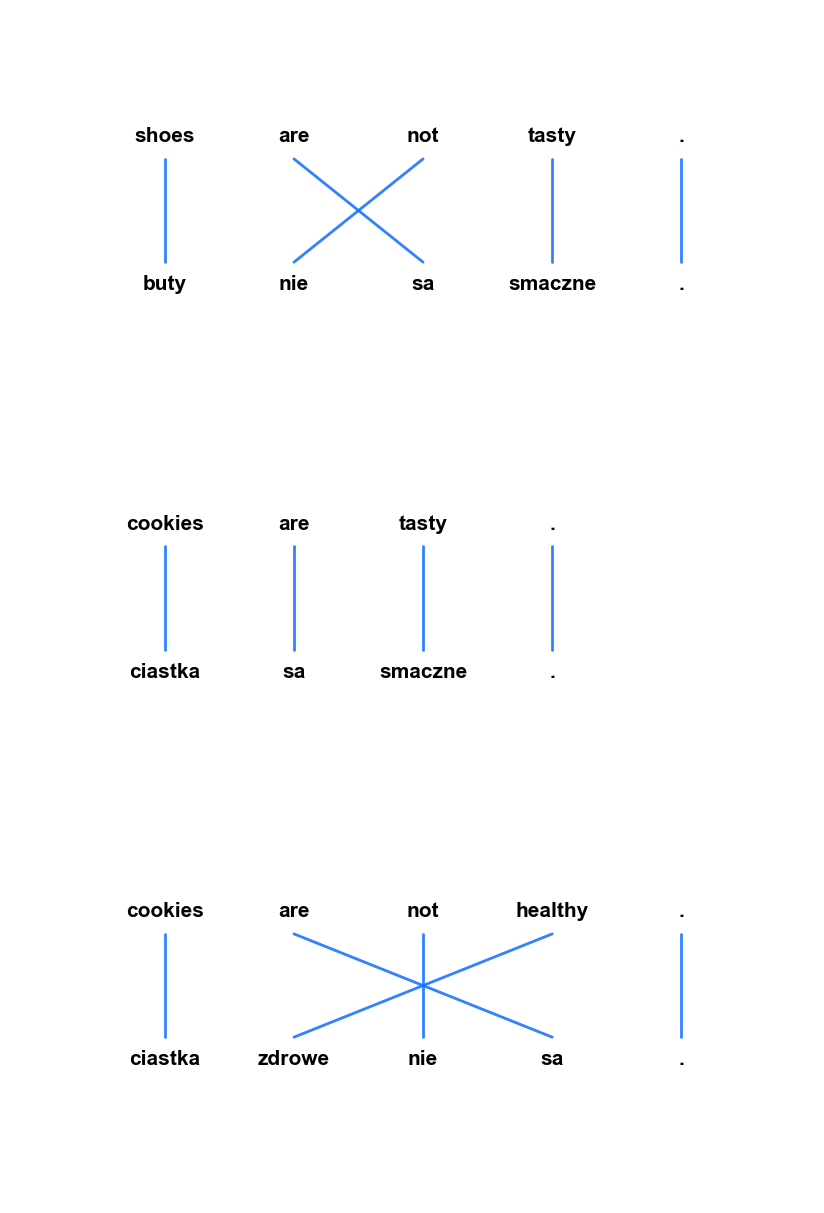

In [16]:
draw_actual_alignments(bitext)

Now we have a definition of $\theta$. It’s simply two tables of numbers: $p(I|J)$, for all pairs of sentence lengths I and J; and $p(f|e)$ for all pairs of co-occurring Foreign and English words $f$ and $e$. Since these numbers represent probabilities, the set of valid assignments of numbers to these tables must follow basic rules of probability.

$$\forall_{e,f} p(f\, |\, e) \in [0,1]$$
$$\forall_{e} \sum_{f} p(f\, |\, e) = 1$$

We’re not going to worry too much about $p(I|J)$ because the sentence lengths are observed, and in any case we don’t need to worry about these parameters if the goal is simply to align sentences. We do however care about $p(f |e)$, which seems difficult to estimate because we haven’t observed the alignments.

### Maximum Likelihood Estimation
Before proceeding, let’s think about how you would estimate $p(f\, |\,e)$ if you actually had observed the align- ments of the sentences. To take an example, suppose that you only ever saw the English word *shoes* aligned to two different Foreign words: three times to *pantofle*, and seven times to *buty*. Intuitively, you might decide that a good setting for $\theta$ in this case is to let $p(pantofle\,|\,shoes) = 0.3$ and $p(buty\,|\,shoes) = 0.7$, since these values correspond to the proportions in the data that you observed. You can calculate them just by adding up and dividing counts.
Why is this reasonable? To understand this, we’ll introduce something called the likelihood function. It’s simply the probability of the data given the parameters.

$$\mathcal{L} (\theta\,|\,D) = p(D\,|\,\theta) = \prod_{n=1}^{N} p(f^{n}\,|\,e^n,a^n)$$

Now, the data is observed, and the parameters are what we want to estimate, so this is really a function from parameters to a probability. It’s reasonable to assume that the data are highly probable under the model, so one possible strategy (there are many!) is to choose parameters $\hat\theta$ that maximize the probability.

$$\hat \theta = argmax\; p_{\theta}(f^{n}, a^n\,|\,e^{n})$$

Whenever you see arg max like in this formulation, you’re looking at a search problem: there are an infinite number of possible assignments for $\theta$ (since the range of each parameter is continuous), so we’re going to have to search for the one that maximizes this expression. Search problems are ubiquitous in artificial intelligence, and machine translation is no exception. For this case, though, the search is trivial, because there is a closed-form solution for $\hat \theta$ when the data described by our model is fully observed.

Let’s return to our intuitive guess about the parameters $p(pantofle\,|\,shoes)$ and $p(buty\,|\,shoes)$. It turns out that this is the maximum likelihood solution! As long as you understand the intuitive strategy of setting probabilities proportional to observations in the data, you’ve understood the key idea behind maximum likelihood, and you should be able to derive simple estimators whenever you have observed data. Although it’s not necessary for this class, you should know that the solution can be derived using basic calculus. For the curious, this is sketched in Appendix A of TODO<TODO tutorial link>.

At this point, let’s consider an algorithm to learn $\theta$ from our hypothetical aligned data that actually instantiates this strategy. It’s pretty simple: we scan the data, observing the alignments and counting them up for each Foreign-English word pair. To obtain probabilities, we simply normalize each count by the number of times that we observed the corresponding English word participating in any alignment.

Of course, this algorithm isn’t completely hypothetical: we often have a small handful of sentences with observed alignments that we have collected from bilingual annotators. We could train using only this observed data, but you might suspect that this wouldn’t produce a good estimate of $\theta$, and you would be right. Think about all the word pairs that you would never see in a few hundred or thousand sentences. How much observed data do you think you would you need to get good estimates?

### Expectation Maximization for Model 1
One problem with the maximum likelihood estimate we sketched above is that for the vast majority of our sentences, the alignment a isn’t observed. Since Model 1 is defined in terms of this alignment, we call the alignment a latent variable (or a hidden variable or, if you’re feeling less charitable, a nuisance variable). Expectation Maximization (EM) is a way to learn the parameters of a latent variable model like IBM Model 1. There are many others, but it is particularly useful to understand EM since it is relatively simple, widely applicable, and related to many other techniques. There are two key ideas in EM. The first is that we are going to replace the observed counts of alignment links with expected counts of alignment links, computed with respect to some previous estimate of $\theta$. The second is that we compute these expected counts with respect to a previous estimate of $\theta$, and iteratively improve it.

Before explaining further let's take a look at how estimates of alignment probability evolve in a space of a couple of EM iterations over our toy data:

In [17]:
%%capture
line_weights = [[w*10 for w in sublist] for sublist in get_line_weights(bitext, num_iter, thetas20)]
coordinates = get_coordinates(bitext)
fig = plt.figure(figsize=(8, 12))
ax = plt.axes()
plt.axis('off')
lines = [ax.plot(xy[0], xy[1],alpha=0.9,linestyle='-',color='#1a75ff')[0] for xy in coordinates['edges']]

In [18]:
anim = FuncAnimation(fig, animate_alignments, init_func=init_alignments, frames=num_iter, interval=1000,
                     blit=True, repeat=False)
HTML(anim.to_html5_video())

# anim.save('alignment.gif', writer='imagemagick', fps=2)

We can also observe how translation probabilities change over iterations. Each row represents translation probability distribution over vocabulary of F for one word from vocabulary of E.

TODO: should be an animation, not a list of pictures


Initialization:



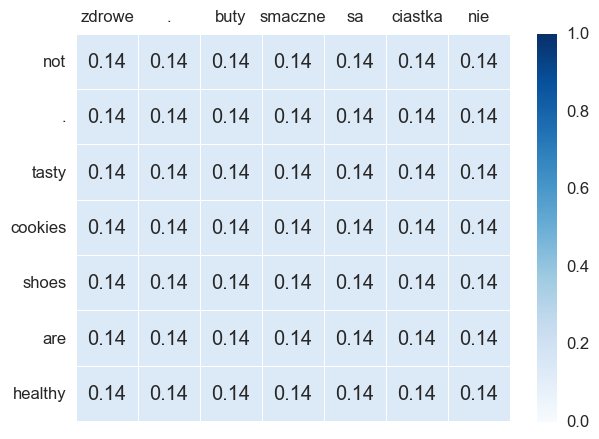


Iteration 1:



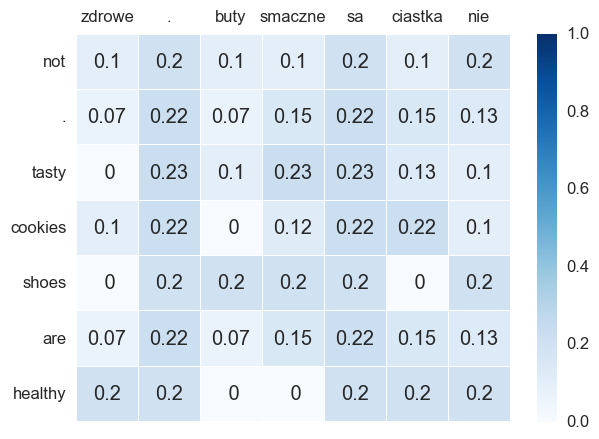


Iteration 2:



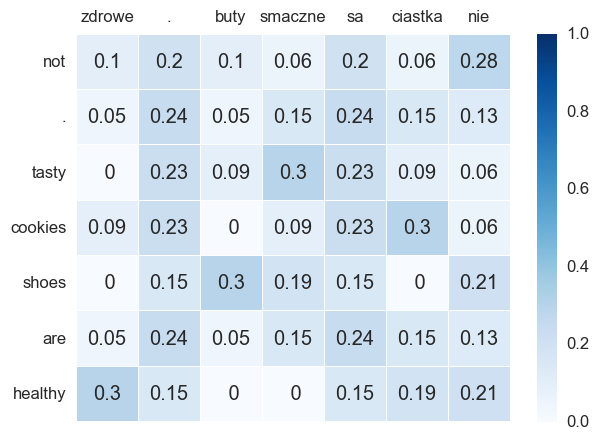


Iteration 3:



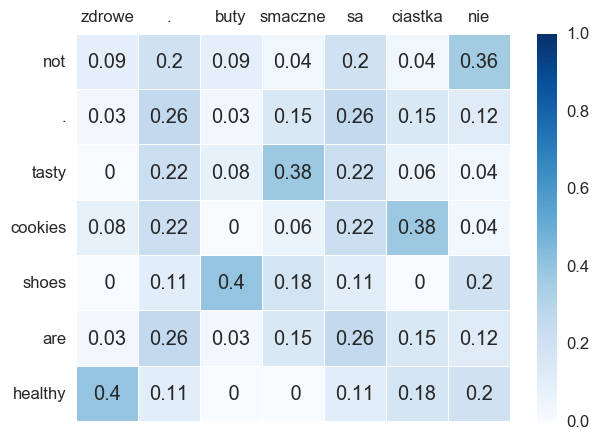


Iteration 4:



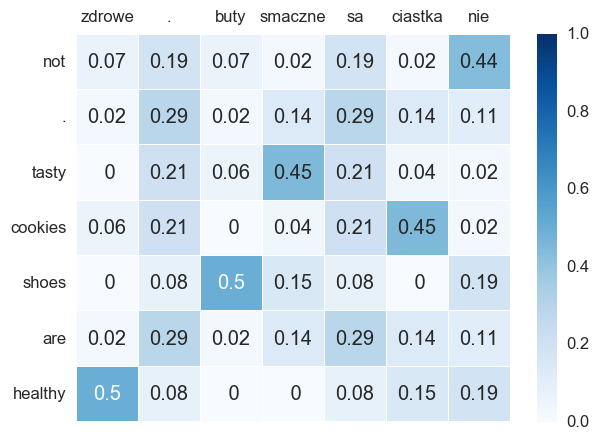


Iteration 5:



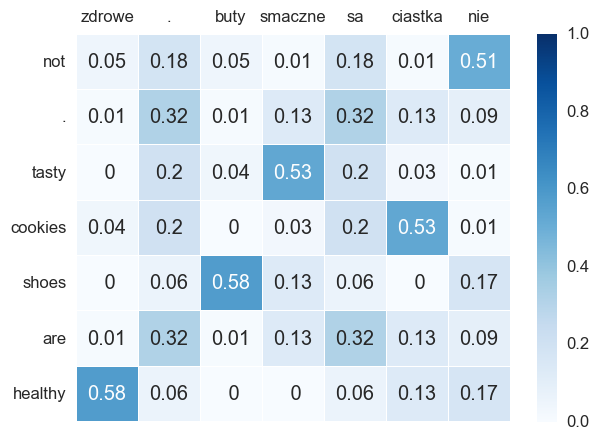


Iteration 6:



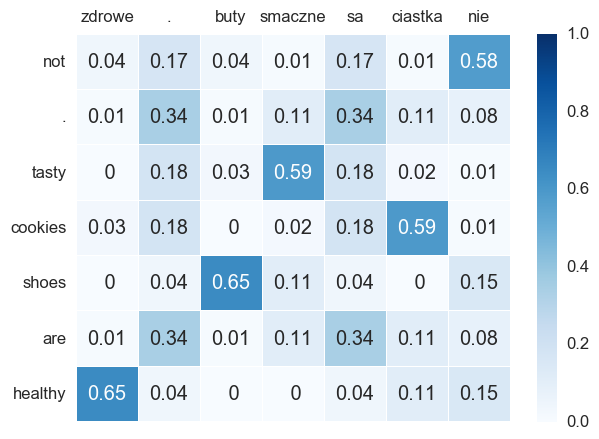


Iteration 7:



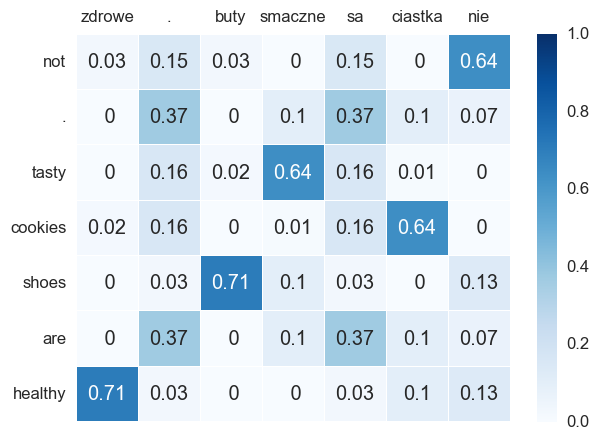


Iteration 8:



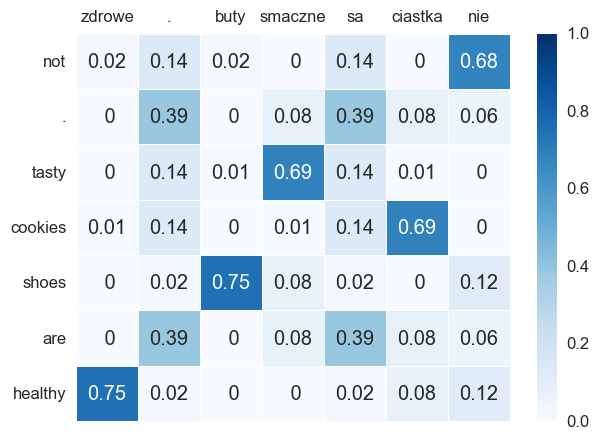


Iteration 9:



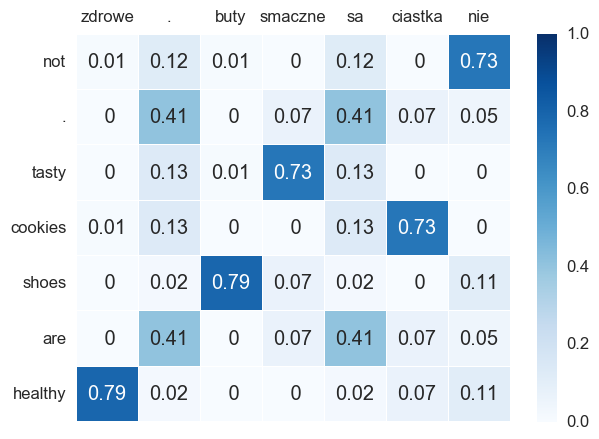


Iteration 10:



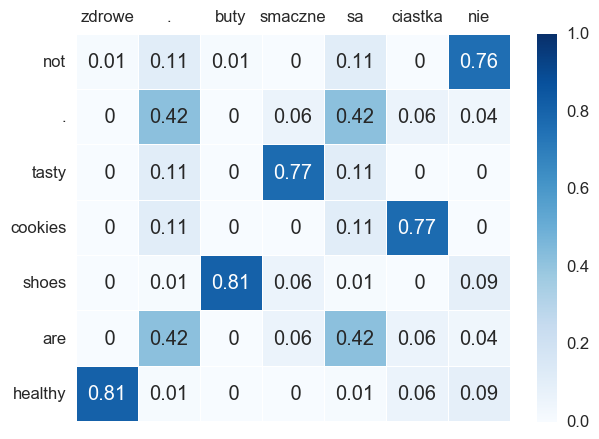

In [19]:
# thetas = get_thetas(bitext, num_iter)
# fig = plt.figure(figsize=(7, 5))
# sns.set(font_scale=1.2)
# sns.set_style({"savefig.dpi": 100})
# theta2frame = pd.DataFrame.from_dict(thetas[0], orient="index")
# data = theta2frame.round(2)
# # plot = sns.heatmap(data, cmap=plt.cm.Blues, linewidths=.1, annot=True, fmt="2g")
# ax = sns.heatmap(data, cmap=plt.cm.Blues, linewidths=.1)
# ax.xaxis.tick_top()
# plt.yticks(rotation=0)
    
# def init():
#     ax.data = data
#     return ax,

# def animate(i):
#     theta2frame = pd.DataFrame.from_dict(thetas[i], orient="index")
#     data = theta2frame.round(2)
#     ax.data = data
#     return ax,

# anim = FuncAnimation(fig, animate, init_func=init, frames=num_iter, interval=1000, repeat_delay=10000)
# HTML(anim.to_html5_video())
# anim.save('translation.gif', writer='imagemagick', fps=2) 

show_translation_tables()

We’ll take our inspiration for EM from maximum likelihood estimation. We need to make a slight change to our likelihood equation in order to account for our new reality.

$$\mathcal{L} (\theta\,|\,D) = p(D\,|\,\theta) = \prod_{n=1}^{N} p(f^{n}\,|\,e^n) = \prod_{n=1}^{N} p(I^{n}\,|\,J^n)\; \sum_{a^{n}} \prod_{i=1}^{I^n} p(a_{i}^{n} \,|\, J^n)\; p(f_{i}^{n}\,|\,e_{a_i}^n) $$

We’re still maximizing the likelihood of the observed data, but since the observed data no longer includes alignments, they’ve been left out of the third expression. To account for this we must marginalize them out in the fourth expression. In other words, since we don’t see the alignment, we add up the probabilities of all possible alignments that could have produced the data, because the rules of probability tell us that this gives us the marginal probability of $f$, which is the quantity that we want to maximize. This idea sounds promising, but introduces a slight wrinkle, in that the sum over the alignments prevents an analytic solution. This means that we’ll have to solve the problem algorithmically, but it’s going to turn out that the intuition behind the algorithm is very similar to the one for maximum likelihood.

Let’s look more closely at the summation over alignments. Suppose that we want to estimate the parameter $p(f\,|\,e)$. Let’s focus our attention on a sentence pair $⟨f,e⟩$ for which Foreign word $f_i = f$ and English word $e_j = e$. The sum over alignments of $⟨f,e⟩$ includes many with a link between $f_i$ and $e_j$, and many without. A question we can ask is: on average, what percentage of the (exponentially many) alignments contain the link between $f_i$ and $e_j$. A formal way of asking this question is: what is the posterior probability $p(a_i = j\,|\,f,e)$ of an alignment link between $f_i$ and $e_j$? That is, given that we observe $f$ and $e$, what is the probability that there’s a link between the two words? We also refer to $p(a_i = j\,|\,f,e)$ as the expected count of the link, and we can calculate it with Bayes’ rule.

$$p(a_i = j\,|\,f,e) = \frac{p(f\,|\,a_i = j,e)\,p(a_i = j\,|\,e)}{p(f\,|\,e)} = \frac{p(f, a_i = j\,|\,e)}{p(f\,|\,e)}$$

This equation says is that the posterior probability is the sum of the probabilities of all of the alignments containing a link between $f_i$ and $e_j$ , divided by the sum of the probability of all of the possible alignments. Already seems somewhat familiar, doesn’t it? This number is simply a probability. Remember that in the MLE case, if we had seen the link we would have incremented our count 1, and if we hadn’t seen it, we wouldn’t have incremented anything at all, which is the same as adding 0. So this posterior probability, which is a number between 0 and 1, is a way of formally expressing our uncertainty about whether a link between fi and ej is actually there. If it’s close to 0, we’re fairly certain there is no link, and if it’s close to 1, we’re fairly certain that there is. If it’s somewhere in the middle, we’re not certain at all. The first key idea of Expectation Maximization is to replace counts of observed events with posterior probabilities of latent events. We need to calculate these posterior probabilities, and to do so we observe that:

$$\frac{p(f, a_i = j\,|\,e)}{p(f\,|\,e)} = \frac{p(I\,|\,J) \sum_{a:a_i=j} \prod_{i\prime=1}^{I}p(a_{i\prime}\,|\,I)\, p(f_{i\prime}\,|\,e_{a_{i\prime}})} {p(I\,|\,J) \sum_{a} \prod_{i=1}^{I}p(a_{i}\,|\,I)\, p(f_{i}\,|\,e_{a_{i}})} = \frac{\sum_{a:a_i=j} \prod_{i\prime=1}^{I} p(f_{i\prime}\,|\,e_{a_{i\prime}})} {\sum_{a} \prod_{i=1}^{I} p(f_{i}\,|\,e_{a_{i}})} $$

Note that we’re able to cancel out the sentence length probability $p(I|J)$. Because $p(a_i|J)$ is uniform, the expression  $\prod_{i=1}^I p(a_i|J)$ is constant across all alignments of the sentence, so we can also cancel it out. This leaves us with an expression written purely in terms of lexical translation probabilities, but both the numerator and denominator are sums over exponentially many terms. Let’s rewrite the equation slightly by enumerating the summations over each element of a.

$$\frac{\sum_{a:a_i=j} \prod_{i\prime=1}^{I} p(f_{i\prime}\,|\,e_{a_{i\prime}})} {\sum_{a} \prod_{i=1}^{I} p(f_{i}\,|\,e_{a_{i}})} = \frac{p(f_i\,|\,e_j)\sum_{a_1=0}^{J}...\sum_{a_{i-1}=0}^{J}\sum_{a_{i+1}=0}^{J}...\sum_{a_I=0}^{J}\prod_{i\prime=1}^I p(f_{i\prime}\,|\,e_{a_{i\prime}})}{\sum_{a_1=0}^{J}...\sum_{a_I=0}^{J}\prod_{i=1}^I p(f_{i}\,|\,e_{a_i})}$$

The denominator is a sum over products of exactly I terms, and we can exploit the regularity of these terms to simplify the expression. The summation over values of $a_1$ first requires $p(f_1|e_1)$ to be multiplied by all possible permutations of probabilities of translations of words $f_2$ through $f_I$. We then multiply $p(f_1|e_2)$ by all permutations, and so on. Exploiting distributivity, we can therefore move the sum over values of $a_1$ inside the product over values of $i$. We can then do the same for the sum over values of $a_2$, and so on. We can similarly manipulate sums and products in the numerator, and simplify by canceling most of the terms.

$$\frac{p(f_i\,|\,e_j)\prod_{i\prime=1}^{I}\sum_{a_1=0}^{J}...\sum_{a_{i-1}=0}^{J}\sum_{a_{i+1}=0}^{J}...\sum_{a_I=0}^{J} p(f_{i\prime}\,|\,e_{a_{i\prime}})}{\prod_{i=1}^I \sum_{a_1=0}^{J}...\sum_{a_I=0}^{J} p(f_{i}\,|\,e_{a_i})} = \frac{p(f_i\,|\,e_j)}{\sum_{a_i=1}^{J}p(f_i\,|\,e_{a_i})} $$

You can inspect probabilities of an alignment links existing between a Foreign word token and all English tokens by executing the next cell. Pick an iteration, sentence pair, and Foreig word by changing the function arguments.

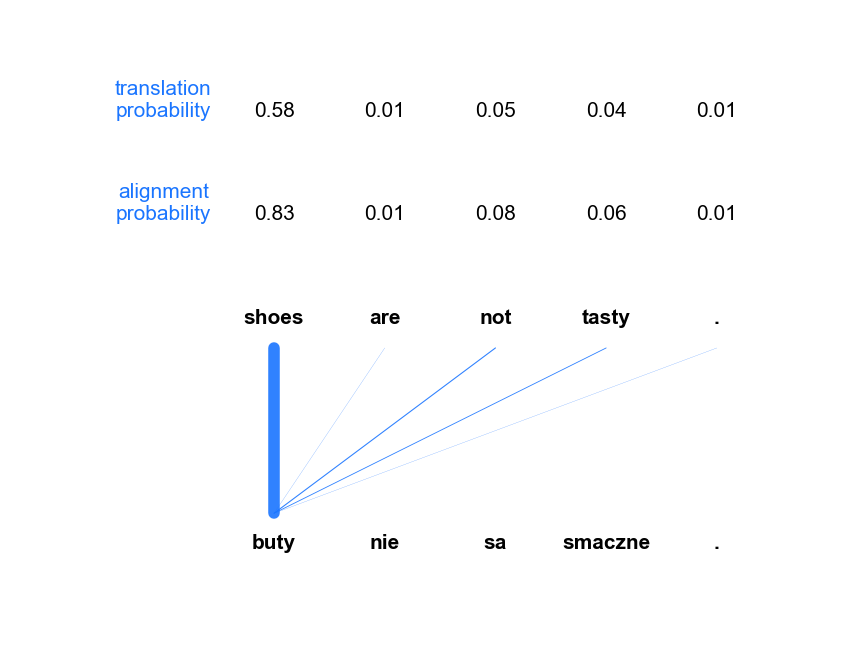

In [24]:
show_sent_data(at_iter=5, sent_index=2, word_index=0)

The final expression of the last equation tells us how to calculate the posterior probability $p(a_i = j\,|\,f, e)$ in terms of a linear number of parameters $p(f\,|\,e)$. Now that we have a way to compute the fractional expected counts of a link, we can collect these counts across the entire dataset, which constitutes the *Expectation* step of EM.

In [25]:
def expectation(theta, bitext):
    e_count = defaultdict(float)
    fe_count = defaultdict(float)
    for (n, (f, e)) in enumerate(bitext):
        for f_i in f:
            z = 0
            for e_j in e:
                z += theta[e_j][f_i]
            for e_j in e:
                c = theta[e_j][f_i] / z
                fe_count[(f_i, e_j)] += c
                e_count[e_j] += c
    return e_count, fe_count

The *Maximization* step is normalization, just as if we were doing maximum likelihood estimation.

In [26]:
def maximization(theta, e_count, fe_count):
    new_theta = deepcopy(theta)
    for e_i in new_theta:
        for f_j in new_theta[e_i]:
            if (f_j, e_i) in fe_count:
                new_theta[e_i][f_j] = fe_count[(f_j, e_i)]/e_count[e_i]
            else:
                new_theta[e_i][f_j] = 0
    return new_theta

Expectation and Maximization steps together constitute one iteration of the training procedure.

In [27]:
def iteration(theta, bitext):
    e_count, fe_count = expectation(theta, bitext)
    new_theta = maximization(theta, e_count, fe_count)
    return new_theta

 To illustrate the parameter updating which happens during an iteration, we can look at the translation probabilities from the previous iteration, the expected alignments derived on their basis, and the translation probabilities for this iteration , derived from the expected alignments:

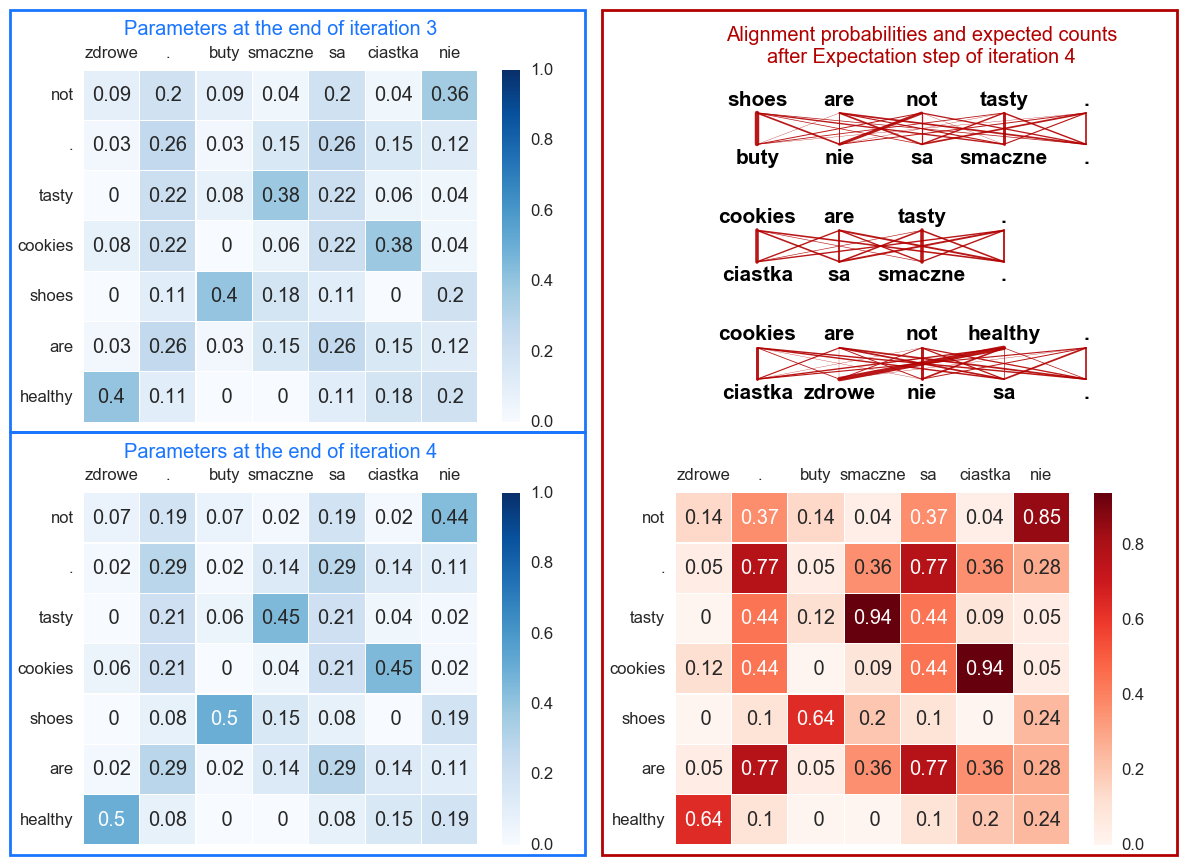

In [32]:
draw_iteration(4, bitext)

You probably noticed a small problem with this arrangement, which is that the parameters used to compute the expectations are what we were searching for in the first place! This problem is not fatal, however. What we can do is assign some initial value to $\theta$, which we’ll call $\theta_0$. We can then compute the expected counts in terms of $\theta_0$, and call the resulting maximum likelihood estimate on the expected counts $\theta_1$. We then use $\theta_1$ to compute expected counts that we use to estimate $\theta_2$, and so on. This idea of iteratively improving our estimate of $\theta$ is the second key idea behind EM.

One straightforward way to initialize $\theta$, which we will follow here, is to say that for each Foreign word, the translation probability distribution over all English words is uniform.

In [33]:
def initialize_theta(bitext):
    f_vocab = set()
    e_vocab = set()
    for (f, e) in bitext:
        f_vocab.update(f)
        e_vocab.update(e)
    theta = {}
    default_p = 1.0/len(f_vocab)
    for e in e_vocab:
        theta[e] = defaultdict(float)
        for f in f_vocab:
            theta[e][f] = default_p
    return theta

****
           QUESTION
    look back at the visualizations of translation and alignment probabilities. Why doesn't the model learn to align '.' to '.' and 'sa' to 'are'? 
****

Now that we know how to execute an iteration of EM training, it's time to ask how many iterations do we need to train our model. In the limit, EM on IBM Model 1 will converge to the true maximum likelihood estimate, a fact we know because of two important properties of EM: that the likelihood of $\theta_{i}$ will always be higher than the likelihood of $\theta_{i-1}$, and that the likelihood function of Model 1 is convex. (The only requirement for reaching the global optimum is that none of the initial parameters is 0.) So in theory, the answers is that you should run it for “a long time”. The empirical answer is somewhat different: most people run EM for a small fixed number of iterations, usually only three to five.

In [34]:
def train1(bitext, num_iter):
    k = 0
    theta = initialize_theta(bitext)
    print("\nInitialization:\n")
    draw_translation_table(k, bitext, theta)
    while k < num_iter:
        k += 1
        theta = iteration(theta, bitext)
        print("\nIteration {}:\n".format(str(k)))
        draw_translation_table(k, bitext, theta)
    return theta

Instead of fixing the iteration number we could check how much better does the model perform after each iteration, and decide to stop if the improvement is below a set threshold.  A reasonable measure of model performance is data likelihood.

In [36]:
def train2(bitext, previous_likelihood=-sys.maxsize):
    threshold = 0.01
    theta = initialize_theta(bitext)
    likelihood = get_data_log_likelihood(bitext, theta)
    while (likelihood - previous_likelihood) > threshold:
        theta = iteration(theta, bitext)
        likelihood = get_data_log_likelihood(bitext, theta)
    return theta

*************************************************
           TASK 1
    write a function which takes bitext and model parameters as input and returns the bitext log likelihood under
    the parameters as output
************************************************* 

We provide you with a log_add function, which returns $ln(x+y)$ when given $ln(x)$ and $ln(y)$. The check if your implementation is correct, execute the next cell.

In [ ]:
def get_data_log_likelihood(bitext, theta):
    #***
    #your code
    #***
    return data_log_likelihood

def log_add(x,y):
    # given x=ln(x') and y=ln(y') returns ln(x'+y')
    return x + np.log(1+ np.exp(y-x))

In [38]:
get_data_log_likelihood(bitext, thetas20[0]) == -1.6823611831060648

True

In [37]:
# TO REMOVE

def get_data_log_likelihood(bitext, theta):
    data_log_likelihood = 0
    for (f, e) in bitext:
        data_log_likelihood += get_pair_likelihood(e,f,theta)
        return data_log_likelihood
    
def get_pair_likelihood(e_sent,f_sent,theta):
    first_column = [np.log(theta[e_j][f_sent[0]]) for e_j in e_sent]
    current_sum = list_log_add(first_column)
    for i in range(1, len(f_sent)):
        next_column = [(np.log(theta[e_j][f_sent[i]]) + current_sum) for e_j in e_sent]
        next_sum = list_log_add(next_column)
        current_sum = next_sum
    return current_sum

def list_log_add(l):
    if len(l) == 1:
        return l[0]
    else:
        new_l = []
        first_sum = log_add(l[0], l[1])
        new_l.append(first_sum)
        new_l.extend(l[2:])
        return list_log_add(new_l)

def log_add(x,y):
    # given x=ln(x') and y=ln(y') returns ln(x'+y')
    return x + np.log(1+ np.exp(y-x))

Having written get_data_log_likelihood( ) you can inspect how log likelihood changes over iterations and visualize why a small number of iterations might be sufficient.

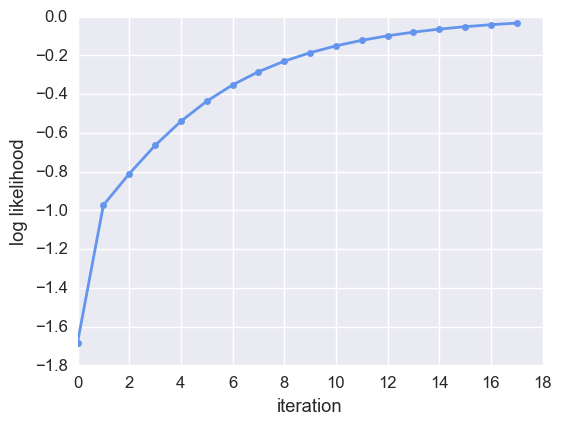

In [39]:
plot_likelihoods(threshold=0.01)

*************************************************
           TASK 2
    write a new θ initialization function
************************************************* 
In thory, whatever the initial $theta$, EM will converge on the true MLE estimate, which makes our simple uniform initializatio adequate. In practice, [Moore(2004)] shows that using heuristic estimates to set initial parameter values can significantly improve final model accuracy.

Your task is to experiment, but not necessarily improve model performance. Try to implement an initialization method that seems sensible to you, and make observations about how and translation probabilitie and data likelihood evolve over iterations, as compared to when uniform initialization is used

In [ ]:
def initialize_theta2(bitext):
    #***
    #your code
    #***
    return theta

In [ ]:
show_translation_tables(initialize=initialize_theta2)

In [ ]:
plot_likelihoods(threshold=0.01, initialize=initialize_theta2)

*************************************************
           TASK 3
    make null alignments possible
************************************************* 
So far we've assumed that each Foreign word is aligned to exactly one English word. However, it's easy to come up with sentence pairs in which for some foreign word there is no source on the English side. For instance, the Polish question particle *czy* in *czy to jest smaczne?* has no equivalent in *is it tasty?*. If we forced *czy* to align to one of the English words we would be in error. Instead, we can append a null token onto the English sentence, to which all target words with no clear source equaivalent can align. If $a_{i} = 0$, this means that $f_{i}$ is not aligned to any word in the English sentence, called null alignment.

You task is to modify the model to accomodate null alignment. You can do this by simply pretending that each English sentence has an extra word in it at position 0, and treat it like any other English word.

To inspect the behaviour of your new model, you should change the data file to data/dev-test-train-null.pl-en

*************************************************
           EXTRA ACTIVITIES
    come up with your own mock data, several sentence pairs long. Try to construct datasets which illustrate problems of IBM Model1, e.g. garbage collection
    
    fun part: play with the Arcturan - Centauri data from lecture 1, to be found in data/dev-test-train-null.cen-act
************************************************* 